In [23]:
# Importing libraries
import pandas as pd
import numpy as np
import string
import re
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [24]:
# Reading Dataset
name = ['sentiment' , 'ids' , 'date', 'flag' , 'user' , 'text']
df = pd.read_csv("Dataset/twitter.csv" ,encoding = 'ISO-8859-1', names= name)

df = df[550000:1050000]
df.sample(5)

,sentiment,ids,date,flag,user,text
1031657,4,1933086698,Tue May 26 22:57:50 PDT 2009,NO_QUERY,assrocket,@wisdomworld Ghandicon 2. Thanks for caring #...
601841,0,2221244508,Thu Jun 18 05:00:17 PDT 2009,NO_QUERY,donnajones,@alkhemist_mark nods &amp; frowns... Just beca...
794197,0,2326893089,Thu Jun 25 07:39:00 PDT 2009,NO_QUERY,kayesinocruz,I missed you Statsoc. I missed my Exte babies!
605697,0,2222347364,Thu Jun 18 06:51:20 PDT 2009,NO_QUERY,HUGQQT,Sooooo like no one is here today. They either ...
711105,0,2258118475,Sat Jun 20 15:24:57 PDT 2009,NO_QUERY,lauresque,Fail attempt to post pic from phone is fail.


In [25]:
# Reaplcing 4 --> 1
df.info()
df.replace({'sentiment' : {4:1}} , inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 550000 to 1049999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  500000 non-null  int64 
 1   ids        500000 non-null  int64 
 2   date       500000 non-null  object
 3   flag       500000 non-null  object
 4   user       500000 non-null  object
 5   text       500000 non-null  object
dtypes: int64(2), object(4)
memory usage: 22.9+ MB


In [26]:
df.shape

(500000, 6)

sentiment
0    250000
1    250000
Name: count, dtype: int64

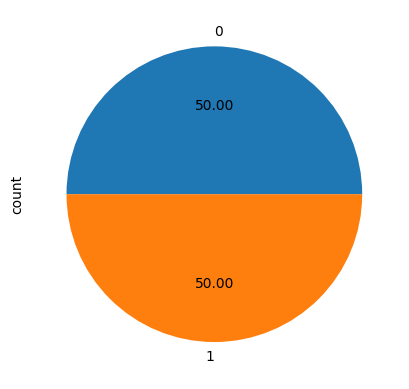

In [27]:
df['sentiment'].value_counts().plot(kind = "pie" , autopct = '%.2f' )
df['sentiment'].value_counts()

In [28]:
df.isnull().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

In [29]:
# Preprocssing of text data

df['text'] = df['text'].str.lower() # convert into lower-case

In [30]:
# Remove punctuation
exclude = string.punctuation 
def remove_pun(text):
    return text.translate(str.maketrans("" , '' , exclude))

df['text'] = df['text'].apply(remove_pun)

df['text'].iloc[:3]
    

550000                        having an orgytoo many girls 
550001    defiance is sooo good i cried when liev schrei...
550002    chuenoi awe thanks but i dont know   ive tried...
Name: text, dtype: object

In [31]:
# Remove HTML tags
def remove_html_tag(text):       
    pattern = re.compile("<.?>")
    return pattern.sub(r'' , text)

df['text'] = df['text'].apply(remove_html_tag)

df['text'].iloc[:3]

550000                        having an orgytoo many girls 
550001    defiance is sooo good i cried when liev schrei...
550002    chuenoi awe thanks but i dont know   ive tried...
Name: text, dtype: object

In [32]:
# Remove Stop Words
stop_words = set(stopwords.words('english'))  

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words[:])

df['text'] = df['text'].apply(remove_stopwords)

df['text'].iloc[:3]


550000                                   orgytoo many girls
550001    defiance sooo good cried liev schreiber saved ...
550002    chuenoi awe thanks dont know ive tried much st...
Name: text, dtype: object

In [33]:
# Convert each word into it's root word
ps = PorterStemmer()  

def stem(text):
    return " ".join([ps.stem(word) for word in text.split()])

df['text'] = df['text'].apply(stem)

df['text'].iloc[:3]

550000                                    orgytoo mani girl
550001    defianc sooo good cri liev schreiber save dani...
550002    chuenoi awe thank dont know ive tri much stuff...
Name: text, dtype: object

In [34]:
# Tokenise the corpus
from gensim.utils import simple_preprocess
from nltk import sent_tokenize
import gensim.models
corpus = []

for doc in df['text']:
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        corpus.append(simple_preprocess(sent))
9

9

In [35]:
# Building gensim Model
model = gensim.models.Word2Vec(
    window = 20 ,
    min_count = 2
)

In [36]:
model.build_vocab(corpus)

In [37]:
#Traning the model
model.train(corpus , total_examples= model.corpus_count , epochs= model.epochs)

(16573984, 19148210)

In [38]:
len(model.wv.index_to_key)

85734

In [39]:
# Function to convert text into vector
def docu_vector(doc):
    doc_words = [word for word in doc.split() if word in model.wv.index_to_key]
    if doc_words:
        return np.mean(model.wv[doc_words], axis=0)
    else:
        return None


In [ ]:
docu_vector(df['text'].values[0]).shape

In [41]:
# transforming the data
from tqdm import tqdm

X = []
for doc in tqdm(df['text'].values):
    X.append(docu_vector(doc))

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [1:12:28<00:00, 114.99it/s]   


In [42]:
# Removing Empty list
y = df['sentiment']
X_filtered = []
y_filtered = []
for i, vector in enumerate(X):
    if vector is not None:
        X_filtered.append(vector)
        y_filtered.append(y.iloc[i])


X_filtered = np.array(X_filtered)
y_filtered = np.array(y_filtered)


In [43]:
X = X_filtered
y = y_filtered

In [44]:
print(X.shape , y.shape)

(497783, 100) (497783,)


In [45]:
# Train test split of the data

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=.2 , random_state=2) 
print(X.shape , X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)

(497783, 100) (398226, 100) (99557, 100)
(398226,) (99557,)


In [47]:
print(X.shape , X_train.shape , X_test.shape)

(497783, 100) (398226, 100) (99557, 100)


In [48]:
# Training the Model ( LogisticRegression )
model = LogisticRegression(max_iter=1000)
model.fit(X_train , y_train)


LogisticRegression(max_iter=1000)

In [49]:
# Accuracy score 
y_pred = model.predict(X_test)
print("The accuracy score for the Logistic Rgression is:" , accuracy_score(y_test , y_pred))

The accuracy score for the Logistic Rgression is: 0.72091364745824


Fine Tuning for different Ml algos

In [51]:
# Traning the model ( Naive - bayes )
Nbc = GaussianNB()
Nbc.fit(X_train , y_train)

# Accuracy Score
y_pred_NBC = Nbc.predict(X_test)
print("Accuracy Socre for Naive bayes is : " ,  accuracy_score(y_test , y_pred_NBC))

Accuracy Socre for Naive bayes is :  0.6677481241901624


In [52]:
# Traning the model ( Decision-Tree )
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train , y_train)

# Accuracy Score
y_pred_dtc = dtc.predict(X_test)
print("Accuracy Socre for Decision tree is : " ,  accuracy_score(y_test , y_pred_dtc))

Accuracy Socre for Decision tree is :  0.6334662555119178


In [53]:
# Traning the model for Random - Forest
rfc = RandomForestClassifier()
rfc.fit(X_train , y_train)

RandomForestClassifier()

In [54]:
# Accuracy Score
y_pred_RF = rfc.predict(X_test)
print("Accuracy Socre for Random forest is : " ,  accuracy_score(y_test , y_pred_RF))

Accuracy Socre for Random forest is :  0.7356087467480941


In [2]:
# Traning the model ( Support - Vector Machine )
from sklearn.svm import SVC
sv = SVC()
sv.fit(X_train , y_train)
 
# Accuracy Score
y_pred_sv = sv.predict(X_test)
print("Accuracy Socre for Decision tree is : " ,  accuracy_score(y_test , y_pred_sv))

Accuracy Socre for Support vector machine is :  0.752436877480941
